In [4]:
import pandas
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import math

# Perspective Correction for Oscilloscope Images

When photographing an oscilloscope screen at an angle, the image becomes distorted. We need to:
1. Detect the screen corners (manually or automatically)
2. Apply a perspective transformation to get a rectangular view
3. This will allow accurate area calculation of Lissajous curves

In [ ]:
# Method 1: Manual perspective correction
# Select 4 corner points of the screen in the image

def correct_perspective_manual(image, src_points, width=800, height=600):
    """
    Corrects perspective distortion using manually selected points.
    
    Parameters:
    - image: input image
    - src_points: 4 corner points of the screen [top-left, top-right, bottom-right, bottom-left]
    - width, height: desired output dimensions
    
    Returns:
    - warped: corrected image
    """
    # Define destination points (rectangle)
    dst_points = np.float32([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ])
    
    src_points = np.float32(src_points)
    
    # Calculate perspective transformation matrix
    M = cv.getPerspectiveTransform(src_points, dst_points)
    
    # Apply transformation
    warped = cv.warpPerspective(image, M, (width, height))
    
    return warped, M

In [5]:
# Method 2: Automatic detection of screen edges (if screen has clear boundaries)

def detect_screen_automatic(image):
    """
    Automatically detects the oscilloscope screen using edge detection.
    Works best if the screen has clear bright edges or rectangular borders.
    
    Returns:
    - corners: 4 corner points of detected screen
    """
    # Convert to grayscale
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv.GaussianBlur(gray, (5, 5), 0)
    
    # Edge detection
    edges = cv.Canny(blurred, 50, 150)
    
    # Find contours
    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Find the largest rectangular contour
    screen_contour = None
    max_area = 0
    
    for contour in contours:
        # Approximate contour to polygon
        epsilon = 0.02 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)
        
        # Check if it's a quadrilateral
        if len(approx) == 4:
            area = cv.contourArea(approx)
            if area > max_area:
                max_area = area
                screen_contour = approx
    
    if screen_contour is not None:
        # Order points: top-left, top-right, bottom-right, bottom-left
        corners = order_points(screen_contour.reshape(4, 2))
        return corners
    else:
        return None


def order_points(pts):
    """Order points in clockwise order: TL, TR, BR, BL"""
    rect = np.zeros((4, 2), dtype="float32")
    
    # Sum: top-left will have smallest sum, bottom-right largest
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # Difference: top-right will have smallest diff, bottom-left largest
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [ ]:
# # Example usage - Load and correct an image

# # Load your oscilloscope image
# img_path = 'path_to_your_image.jpg'  # Replace with your image path
# img = cv.imread(img_path)

# if img is None:
#     print("Error: Could not load image. Please update the path.")
# else:
#     # Display original image
#     plt.figure(figsize=(15, 5))
    
#     plt.subplot(1, 3, 1)
#     plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#     plt.title('Original Image')
#     plt.axis('off')
    
#     # Method 1: Manual selection (RECOMMENDED for precise results)
#     # You need to click on 4 corners in order: top-left, top-right, bottom-right, bottom-left
#     # Or define them manually:
#     src_points = [
#         [100, 50],    # top-left
#         [700, 60],    # top-right
#         [710, 550],   # bottom-right
#         [90, 540]     # bottom-left
#     ]
    
#     corrected_manual, M = correct_perspective_manual(img, src_points, width=800, height=600)
    
#     plt.subplot(1, 3, 2)
#     plt.imshow(cv.cvtColor(corrected_manual, cv.COLOR_BGR2RGB))
#     plt.title('Corrected (Manual Points)')
#     plt.axis('off')
    
#     # Method 2: Try automatic detection
#     corners = detect_screen_automatic(img)
#     if corners is not None:
#         print("Detected corners:", corners)
#         corrected_auto, M_auto = correct_perspective_manual(img, corners, width=800, height=600)
        
#         plt.subplot(1, 3, 3)
#         plt.imshow(cv.cvtColor(corrected_auto, cv.COLOR_BGR2RGB))
#         plt.title('Corrected (Auto-detected)')
#         plt.axis('off')
#     else:
#         print("Automatic detection failed. Use manual method.")
    
#     plt.tight_layout()
#     plt.show()

In [ ]:
# Interactive corner selection with mouse clicks

def select_corners_interactive(image):
    """
    Interactive corner selection using mouse clicks.
    Click on 4 corners in order: top-left, top-right, bottom-right, bottom-left
    Press 'r' to reset, 'q' to finish
    """
    corners = []
    img_copy = image.copy()
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal corners, img_copy
        
        if event == cv.EVENT_LBUTTONDOWN and len(corners) < 4:
            corners.append([x, y])
            cv.circle(img_copy, (x, y), 5, (0, 255, 0), -1)
            cv.putText(img_copy, str(len(corners)), (x+10, y+10), 
                      cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv.imshow('Select Corners', img_copy)
    
    cv.namedWindow('Select Corners')
    cv.setMouseCallback('Select Corners', mouse_callback)
    cv.imshow('Select Corners', img_copy)
    
    print("Click on 4 corners: 1-TL, 2-TR, 3-BR, 4-BL")
    print("Press 'r' to reset, 'q' when done")
    
    while True:
        key = cv.waitKey(1) & 0xFF
        
        if key == ord('r'):
            corners = []
            img_copy = image.copy()
            cv.imshow('Select Corners', img_copy)
        elif key == ord('q') or len(corners) == 4:
            break
    
    cv.destroyAllWindows()
    return corners if len(corners) == 4 else None

In [ ]:
# Calculate area of Lissajous curve after perspective correction

def calculate_lissajous_area(corrected_image, threshold_method='otsu'):
    """
    Calculate the area of a Lissajous curve in the corrected image.
    
    Parameters:
    - corrected_image: perspective-corrected image
    - threshold_method: 'otsu', 'adaptive', or 'manual'
    
    Returns:
    - area: area in pixels
    - binary_image: thresholded image showing the curve
    """
    # Convert to grayscale
    gray = cv.cvtColor(corrected_image, cv.COLOR_BGR2GRAY)
    
    # Apply thresholding to isolate the bright curve
    if threshold_method == 'otsu':
        _, binary = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    elif threshold_method == 'adaptive':
        binary = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv.THRESH_BINARY, 11, 2)
    else:  # manual
        _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    
    # Optional: morphological operations to clean up the curve
    kernel = np.ones((3, 3), np.uint8)
    binary = cv.morphologyEx(binary, cv.MORPH_CLOSE, kernel)
    
    # Find contours
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # Calculate total area (sum of all contours or largest contour)
    if len(contours) > 0:
        # Get the largest contour (assuming it's the Lissajous curve)
        largest_contour = max(contours, key=cv.contourArea)
        area_pixels = cv.contourArea(largest_contour)
        
        # Alternative: sum all contour areas
        # area_pixels = sum(cv.contourArea(c) for c in contours)
        
        # Draw contour for visualization
        result = corrected_image.copy()
        cv.drawContours(result, [largest_contour], -1, (0, 255, 0), 2)
        
        return area_pixels, binary, result
    else:
        return 0, binary, corrected_image

# Example: Calculate area
# area_px, binary_img, result_img = calculate_lissajous_area(corrected_manual)
# print(f"Area of Lissajous curve: {area_px} pixels")

# To convert to real units (cm², mm²), you need a calibration:
# If you know the screen dimensions (e.g., 10cm x 8cm):
# screen_width_cm = 10
# screen_height_cm = 8
# pixels_per_cm_x = corrected_image.shape[1] / screen_width_cm
# pixels_per_cm_y = corrected_image.shape[0] / screen_height_cm
# area_cm2 = area_px / (pixels_per_cm_x * pixels_per_cm_y)

## Complete Workflow Example

Here's the recommended workflow:

1. **Load your oscilloscope image**
2. **Correct perspective** using one of these methods:
   - **Manual points** (most accurate) - define 4 corner coordinates
   - **Interactive selection** - click on corners with mouse
   - **Automatic detection** - if screen edges are clearly visible
3. **Calculate area** of the Lissajous curve
4. **Convert to real units** if you know screen dimensions

In [ ]:
# # COMPLETE WORKFLOW - Replace paths and coordinates with your values

# # Step 1: Load image
# img_path = 'your_oscilloscope_image.jpg'  # UPDATE THIS PATH
# img = cv.imread(img_path)

# if img is not None:
#     print(f"Image loaded: {img.shape}")
    
#     # Step 2a: OPTION 1 - Use interactive selection
#     # Uncomment the following lines to select corners interactively:
#     # corners = select_corners_interactive(img)
#     # if corners:
#     #     corrected, M = correct_perspective_manual(img, corners, width=800, height=600)
    
#     # Step 2b: OPTION 2 - Use manual coordinates
#     # Measure or estimate the 4 corners of your oscilloscope screen
#     src_points = [
#         [100, 50],    # top-left corner (x, y)
#         [700, 60],    # top-right corner
#         [710, 550],   # bottom-right corner
#         [90, 540]     # bottom-left corner
#     ]
#     corrected, M = correct_perspective_manual(img, src_points, width=800, height=600)
    
#     # Step 3: Calculate area
#     area_px, binary, result = calculate_lissajous_area(corrected, threshold_method='otsu')
    
#     # Step 4: Display results
#     fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
#     axes[0, 0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
#     axes[0, 0].set_title('Original Image')
#     axes[0, 0].axis('off')
    
#     axes[0, 1].imshow(cv.cvtColor(corrected, cv.COLOR_BGR2RGB))
#     axes[0, 1].set_title('Perspective Corrected')
#     axes[0, 1].axis('off')
    
#     axes[1, 0].imshow(binary, cmap='gray')
#     axes[1, 0].set_title('Thresholded Curve')
#     axes[1, 0].axis('off')
    
#     axes[1, 1].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
#     axes[1, 1].set_title(f'Detected Curve\nArea: {area_px:.0f} pixels²')
#     axes[1, 1].axis('off')
    
#     plt.tight_layout()
#     plt.show()
    
#     print(f"\nArea of Lissajous curve: {area_px:.2f} pixels²")
    
#     # Step 5: Convert to real units (optional)
#     # If you know the actual screen dimensions:
#     screen_width_cm = 10.0   # UPDATE with actual width
#     screen_height_cm = 8.0   # UPDATE with actual height
    
#     img_height, img_width = corrected.shape[:2]
#     pixels_per_cm_x = img_width / screen_width_cm
#     pixels_per_cm_y = img_height / screen_height_cm
#     area_cm2 = area_px / (pixels_per_cm_x * pixels_per_cm_y)
    
#     print(f"Area in real units: {area_cm2:.2f} cm²")
    
# else:
#     print(f"Could not load image from: {img_path}")
#     print("Please update the img_path variable with the correct path to your image.")

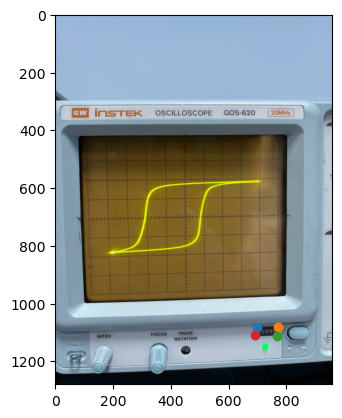

In [10]:
filepath = 'photo_2025-09-10_16-31-06.jpg'

image = cv.imread(filepath)

points = detect_screen_automatic(image)
order_points(points)
# print(image)
fix, ax = plt.subplots()

for x, y in points:
    ax.scatter(x, y)

ax.imshow(image)

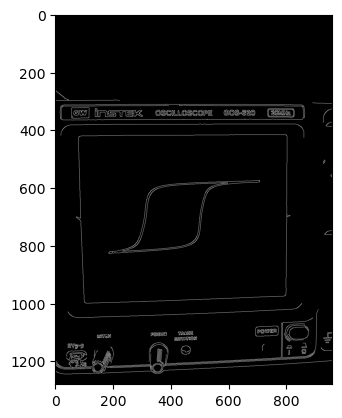

In [16]:
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv.GaussianBlur(gray, (5, 5), 0)

# Edge detection
edges = cv.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

plt.imshow(edges, cmap='gray')

In [20]:
print(len(contours))

120
